## A Notebook Using Herbie to Look at HRRR Cloud Forecasts

This notebook uses the new Herbie package to download HRRR fields, fix some metadata, fix some dimensions and merge fields. It also grabs one column of geopotential heights and uses this as a vertical axis to look at the structure of clouds over Chicago. The plan is to extract these columns and study the performance of HRRR and other models over Chicago using Argonne's scanning Doppler LIDAR, Ceilometer and other instruments. 

This notebook, given it takes 15 minutes to work on **the best** internet connections, inadervtantly makes the case for server side subsetting like the [HRRR ZARR archives](https://mesowest.utah.edu/html/hrrr/). This makes heavy use of [xarray](https://docs.xarray.dev/en/stable/) and we are always grateful to [Pangeo](https://pangeo.io/). 

Scott Collis, Argonne National Laboratory. [Twitter](https://twitter.com/Cyclogenesis_au) [GitHub](https://github.com/scollis)


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import xarray as xr

import cartopy.feature as cfeature

from herbie import  FastHerbie

# I like Py-ART's colorblind freindly colormaps
from pyart.graph import cm_colorblind 

import time
import warnings

#I will put some PRs into Herbie, we get a bunch of warnings with the regex calls
warnings.filterwarnings(action='ignore')


Set the start time of the model, number of forecast hours and how many cores to use and how many parallel downloads. 

In [28]:
tbegin = time.time() #Timing

mt = "2023-01-20 00:00"
nfcst = 47
nprocs = 5
source = 'aws'

Get the full four dimensional fields. **This is memory hungry, another case for the Pangeo lazy loading** on fast connections the downloads are faster than the loading. 

This downloads and loads grib files for cloud ice and cloud water mixing ratio into xarray. It also renames variables and fixes metadata for the ice fields. 

In [29]:
#Regex query string. Cloud water and cloud ice.
#See https://www.nco.ncep.noaa.gov/pmb/products/hrrr/hrrr.t00z.wrfnatf02.grib2.shtml
qstr = "(:CIMIXR:|:CLMR:)"
FH = FastHerbie([mt], model="hrrr",product="nat",source=source, fxx=range(0,nfcst))

#Download the subsets contianing the cloud fields
FH.download(qstr, max_threads=nprocs)
print('Downloaded')

ds_clouds = FH.xarray(qstr, remove_grib=True)
#Load downloaded fields into a xarray dataset

ds_clouds = ds_clouds.rename({'unknown' : 'cloudice', 'clwmr' : 'cloudwater'})
ds_clouds.cloudice.attrs['units'] = 'kg/kg'
ds_clouds.cloudice.attrs['long_name'] = 'Cloud ice mixing ratio'

#This needs a good (and cheap) internet connection... ONE HOUR on my connection
tcloud = time.time()

👨🏻‍🏭 Created directory: [/Users/scollis/data/hrrr/20230120]


In [30]:

FH = FastHerbie([mt], model="hrrr", fxx=range(0,nfcst), source=source)
FH.download("(TMP|DPT):2 m", max_threads=nprocs)
ds_t_and_dp = FH.xarray("(TMP|DPT):2 m", remove_grib=True)

ttemps = time.time()

In [31]:
qstr = '(' 
for i in range(nfcst):
    if i != nfcst -1:
        qstr = qstr +  f':APCP:surface:{i}-{i+1} ho*|'
    else:
        qstr = qstr +  f':APCP:surface:{i}-{i+1} ho*)'

H = Herbie(
    mt,  # model run date
    model="hrrr",  # model name
    product="sfc",  # model produce name (model dependent)
    fxx=24,  # forecast lead time
)
H.read_idx(searchString=qstr)


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2023-Jan-20 00:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
89,90,64795742,65269962,64795742-65269962,2023-01-20,2023-01-21,APCP,surface,23-24 hour acc fcst,:APCP:surface:23-24 hour acc fcst


In [32]:


FH = FastHerbie([mt], model="hrrr",source=source, fxx=range(1,nfcst))
FH.download(qstr, max_threads=nprocs) #This needs a good (and cheap) internet connection... ~1m on my connection
ds_rain = FH.xarray(qstr, remove_grib=True)

ds_rain = xr.concat([ds_rain.isel(step=0), ds_rain], dim='step')
ds_rain['step'] = ds_clouds['step']
ds_rain['valid_time'] = ds_clouds['valid_time']
ds_rain = ds_rain.rename({'tp': 'rain_accum_1hr'})

tprecip = time.time()

In [33]:
#Get vertical axis
FH = FastHerbie([mt], model="hrrr",product="nat",source=source, fxx=[0])
FH.download(':HGT:.*hybrid', max_threads=1) 
ds_heights = FH.xarray(':HGT:.*hybrid', remove_grib=True)

taxis = time.time()

In [34]:
ds_precip = xr.merge([ds_rain, ds_clouds, ds_t_and_dp])
ds_precip['gph_zero_time'] = ds_heights.gh



In [35]:
ds_precip

<xarray.Dataset>
Dimensions:              (step: 47, y: 1059, x: 1799, hybrid: 50)
Coordinates:
    time                 datetime64[ns] 2023-01-20
  * step                 (step) timedelta64[ns] 00:00:00 ... 1 days 22:00:00
    surface              float64 0.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           (step) datetime64[ns] 2023-01-20 ... 2023-01-21T22:0...
  * hybrid               (hybrid) float64 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    heightAboveGround    float64 2.0
Dimensions without coordinates: y, x
Data variables:
    rain_accum_1hr       (y, x, step) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    gribfile_projection  (step) object None None None None ... None None None
    cloudice             (step, hybrid, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    cloudwater           (step, hybrid, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    t2m                  (step, y, x) float32 293.1 293.1 293.1 ... 270.1 270.1
    d2m                  (step, y, x) float32 285.1 285.1 285.2 ... 267.2 267.2
    gph_zero_time        (hybrid, y, x) float32 10.67 10.67 ... 2.644e+04
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    searchString:            (:APCP:surface:0-1 ho*|:APCP:surface:1-2 ho*|:AP...

In [36]:
dsi = ds_precip.herbie.nearest_points([(-87.6298, 41.8781), (-87.9789, 41.7183), (-87.9646831, 41.8031498)], 
                               names=["Chicago", "Argonne", "Barn"])
dsi

<xarray.Dataset>
Dimensions:              (step: 47, point: 3, hybrid: 50)
Coordinates:
    time                 datetime64[ns] 2023-01-20
  * step                 (step) timedelta64[ns] 00:00:00 ... 1 days 22:00:00
    surface              float64 0.0
    latitude             (point) float64 41.88 41.71 41.79
    longitude            (point) float64 272.4 272.0 272.0
    valid_time           (step) datetime64[ns] 2023-01-20 ... 2023-01-21T22:0...
    heightAboveGround    float64 2.0
    metpy_crs            object Projection: lambert_conformal_conic
  * hybrid               (hybrid) float64 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    y                    (point) float64 4.197e+05 3.987e+05 4.077e+05
    x                    (point) float64 8.185e+05 7.915e+05 7.915e+05
  * point                (point) <U7 'Chicago' 'Argonne' 'Barn'
Data variables:
    rain_accum_1hr       (point, step) float32 0.042 0.042 0.017 ... 0.017 0.01
    gribfile_projection  (point, step) object None None None ... None None None
    cloudice             (point, step, hybrid) float32 0.0 0.0 0.0 ... 0.0 0.0
    cloudwater           (point, step, hybrid) float32 0.0 0.0 0.0 ... 0.0 0.0
    t2m                  (point, step) float32 275.5 275.2 275.2 ... 272.2 272.2
    d2m                  (point, step) float32 275.1 274.6 274.3 ... 269.4 269.4
    gph_zero_time        (point, hybrid) float32 185.0 212.2 ... 2.722e+04
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    searchString:            (:APCP:surface:0-1 ho*|:APCP:surface:1-2 ho*|:AP...

(0.0, 15000.0)

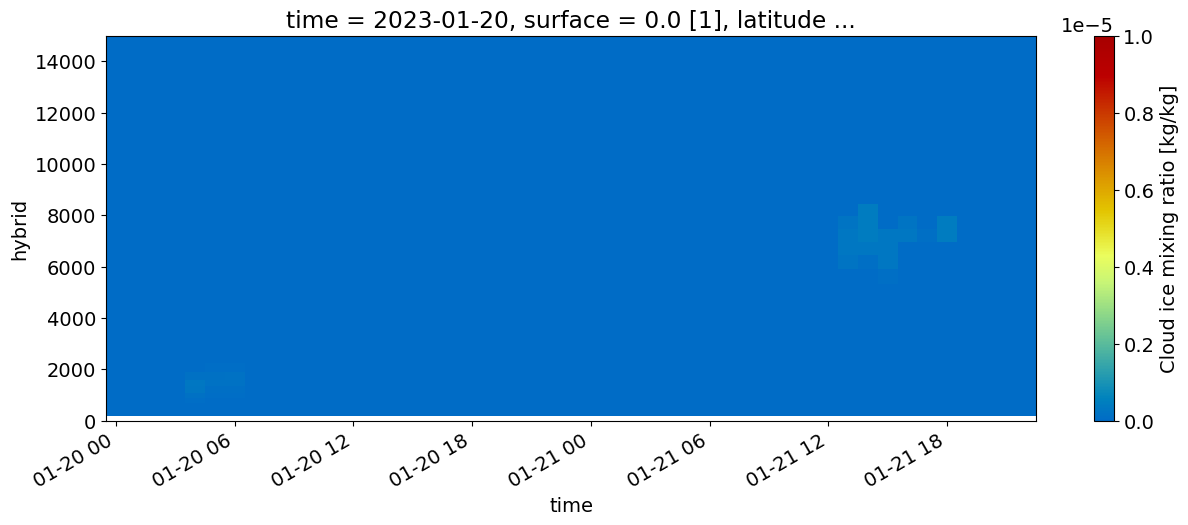

In [37]:
plt.figure(figsize=[15,5])
dsi.isel(point=0).set_index(hybrid="gph_zero_time").cloudice.plot(x="valid_time", vmin=0, vmax=0.00001, 
                                                        cmap = cm_colorblind.HomeyerRainbow)
plt.ylim([0,15000])

(0.0, 15000.0)

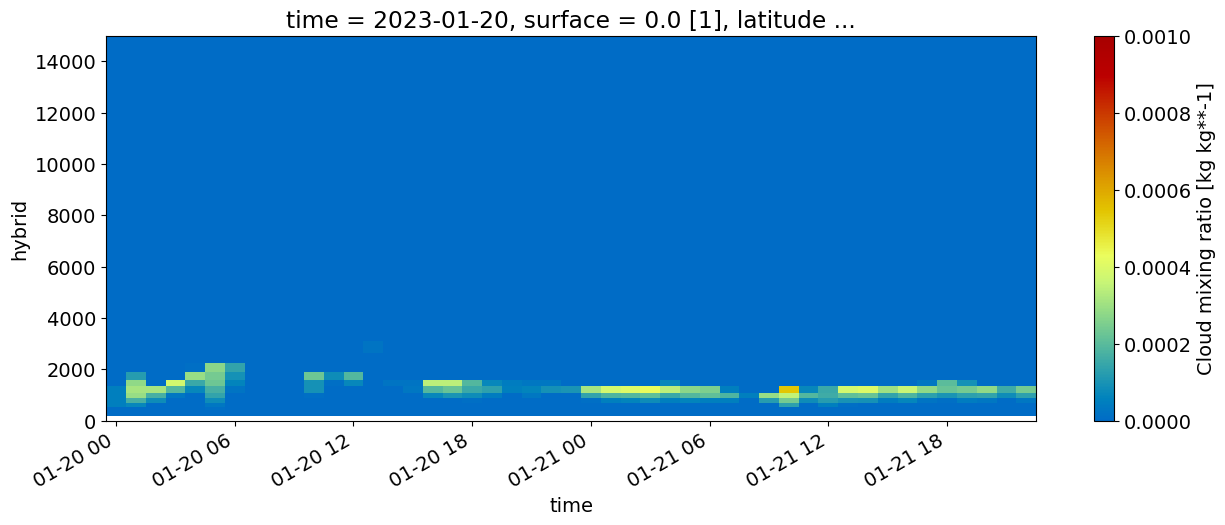

In [38]:
plt.figure(figsize=[15,5])
dsi.isel(point=0).set_index(hybrid="gph_zero_time").cloudwater.plot(x="valid_time", vmin=0, vmax=0.001, 
                                                        cmap = cm_colorblind.HomeyerRainbow)
plt.ylim([0,15000])

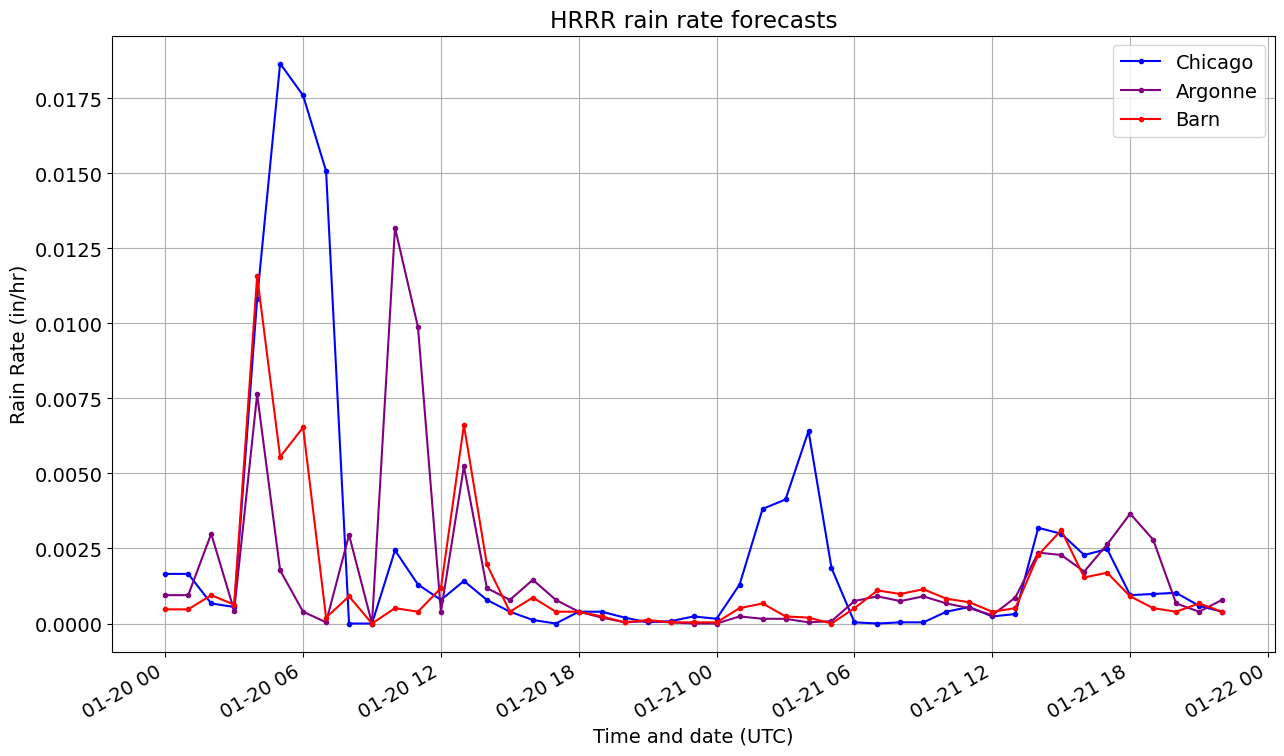

In [39]:
inches_per_mm = 0.0393701

plt.figure(figsize=[15,8])
(dsi.rain_accum_1hr*inches_per_mm).isel(point=0).plot(color='blue', 
                                                      x="valid_time", marker=".", label=dsi.point[0].values)
(dsi.rain_accum_1hr*inches_per_mm).isel(point=1).plot(color='purple', 
                                                      x="valid_time", marker=".", label=dsi.point[1].values)
(dsi.rain_accum_1hr*inches_per_mm).isel(point=2).plot(color='red', 
                                                      x="valid_time", marker=".", label=dsi.point[2].values)

plt.grid()
plt.ylabel('Rain Rate (in/hr)')
plt.xlabel('Time and date (UTC)')
plt.title('HRRR rain rate forecasts')


plt.legend()

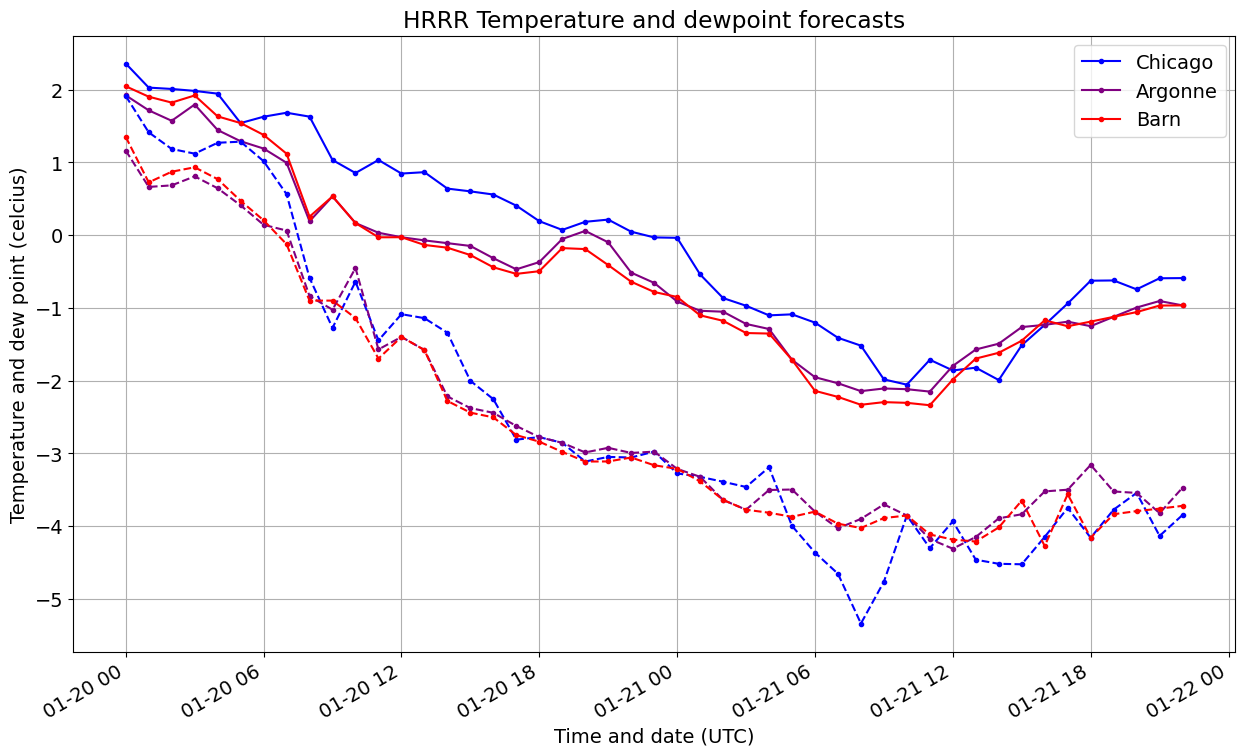

In [40]:
plt.figure(figsize=[15,8])
(dsi.t2m - 273.15).isel(point=0).plot(color='blue', x="valid_time", marker=".", label=dsi.point[0].values)
(dsi.t2m - 273.15).isel(point=1).plot(color='purple', x="valid_time", marker=".", label=dsi.point[1].values)
(dsi.t2m - 273.15).isel(point=2).plot(color='red', x="valid_time", marker=".", label=dsi.point[2].values)

(dsi.d2m - 273.15).isel(point=0).plot(color='blue', x="valid_time", marker=".", linestyle='dashed')
(dsi.d2m - 273.15).isel(point=1).plot(color='purple', x="valid_time", marker=".", linestyle='dashed')
(dsi.d2m - 273.15).isel(point=2).plot(color='red', x="valid_time", marker=".", linestyle='dashed')

plt.grid()
plt.ylabel('Temperature and dew point (celcius)')
plt.xlabel('Time and date (UTC)')
plt.title('HRRR Temperature and dewpoint forecasts')


plt.legend()

Text(0.5, 1.0, 'HRRR rain rate forecasts')

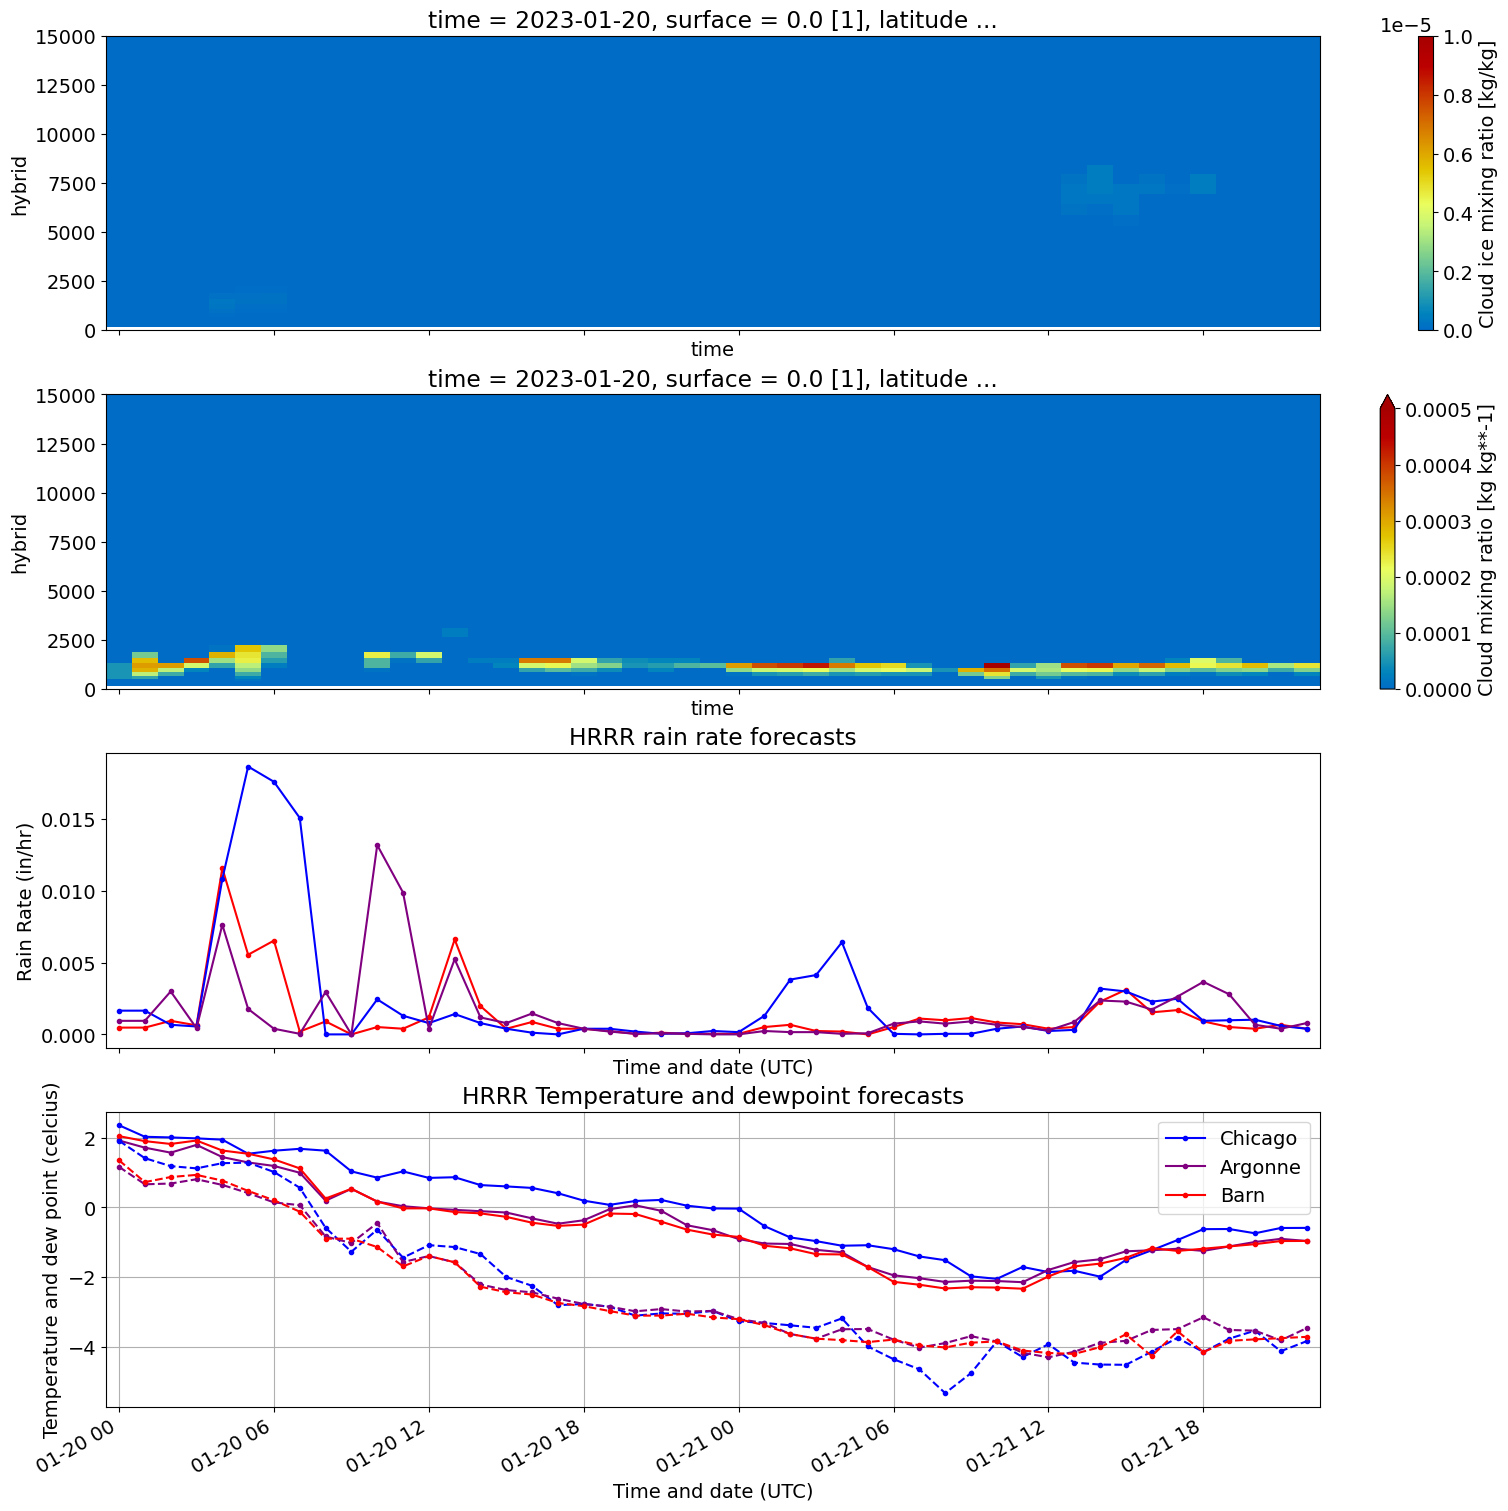

In [41]:
fig, (ax1, ax2, ax3, ax4)  = plt.subplots(nrows = 4, sharex=True, constrained_layout=True, figsize=[15,15])

dsi.isel(point=0).set_index(hybrid="gph_zero_time").cloudice.plot(x="valid_time", vmin=0, vmax=0.00001, 
                                                        cmap = cm_colorblind.HomeyerRainbow, ax=ax1)


dsi.isel(point=0).set_index(hybrid="gph_zero_time").cloudwater.plot(x="valid_time", vmin=0, vmax=0.0005, 
                                                        cmap = cm_colorblind.HomeyerRainbow, ax=ax2)


(dsi.rain_accum_1hr*inches_per_mm).isel(point=2).plot(color='red', 
                                                      x="valid_time", marker=".", 
                                                      label=dsi.point[2].values,
                                                     ax=ax3)


(dsi.rain_accum_1hr*inches_per_mm).isel(point=0).plot(color='blue', 
                                                      x="valid_time", marker=".", 
                                                      label=dsi.point[0].values,
                                                     ax = ax3)

(dsi.rain_accum_1hr*inches_per_mm).isel(point=1).plot(color='purple', 
                                                      x="valid_time", marker=".",
                                                      label=dsi.point[1].values,
                                                     ax=ax3)




(dsi.t2m - 273.15).isel(point=0).plot(color='blue', x="valid_time", marker=".", label=dsi.point[0].values, ax=ax4)
(dsi.t2m - 273.15).isel(point=1).plot(color='purple', x="valid_time", marker=".", label=dsi.point[1].values, ax=ax4)
(dsi.t2m - 273.15).isel(point=2).plot(color='red', x="valid_time", marker=".", label=dsi.point[2].values, ax=ax4)

(dsi.d2m - 273.15).isel(point=0).plot(color='blue', x="valid_time", marker=".", linestyle='dashed', ax=ax4)
(dsi.d2m - 273.15).isel(point=1).plot(color='purple', x="valid_time", marker=".", linestyle='dashed', ax=ax4)
(dsi.d2m - 273.15).isel(point=2).plot(color='red', x="valid_time", marker=".", linestyle='dashed', ax=ax4)

#plt.grid()
ax4.set_ylabel('Temperature and dew point (celcius)')
ax4.set_xlabel('Time and date (UTC)')
ax4.set_title('HRRR Temperature and dewpoint forecasts')


plt.legend()

ax1.set_ylim([0, 15000])
ax2.set_ylim([0, 15000])
#ax3.set_ylim([0,.5])
plt.grid()
ax3.set_ylabel('Rain Rate (in/hr)')
ax3.set_xlabel('Time and date (UTC)')
ax3.set_title('HRRR rain rate forecasts')

#plt.tight_layout()

#box_three = ax3.get_position().extents
#ax3.set_position([box_three[0], box_three[1], .5, box_three[3]])




#box_one = ax1.get_position().extents
#box_three = ax3.get_position().extents
#ax3.set_position([box_three[0], box_three[1], box_three[2], box_three[3]])


In [42]:
print((taxis - tbegin)/3600.)
#print((tice-tbegin)/3600.)
#print((twater-tice)/3600.)


0.643652873635292


AWS

print((taxis - tbegin)/3600.)
print((tice-tbegin)/3600.)
print((twater-tice)/3600.)

1.0796767627530628
0.5272265805138482
0.4292565578222275

10 workers


print((taxis - tbegin)/3600.)
print((tice-tbegin)/3600.)
print((twater-tice)/3600.)
Google at ornl
0.9961472266250186
0.4442499836285909
0.4609267177184423
20 workers


In [17]:
#scratch
#%%capture 
#Handles warnings..
#qstr = ":CLMR:"
#
#FH = FastHerbie([mt], model="hrrr",product="nat",source=source, fxx=range(0,nfcst))
#FH.download(qstr, max_threads=nprocs)
#ds_water = FH.xarray(qstr, remove_grib=True)
#ds_water = ds_water.rename({'clwmr' : 'cloudwater'})

#twater = time.time()


In [18]:
ds_clouds.cloudice['units'] = 'kg/kg'
ds_clouds.cloudice['long_name'] = 'Cloud ice mixing ratio'


In [19]:
dsi['cloudice']['units'] = 'foo'

In [20]:
ds_clouds.cloudice.attrs['units'] = 'kg/kg'
ds_clouds.cloudice['long_name'] = 'Cloud ice mixing ratio'


In [21]:
ds_clouds.cloudice.units

'kg/kg'